# Pattern Task

## Hypothesis
Convolutional neural networks learn to separate noisy images from structured images with less training examples than fully connected neural networks.

## Measurement

We will measure the gap between the two models in the number of training examples required to exceed an accuracy of $\epsilon$ as a function of the side length $L$ of the image.

## Training Data

Generating the labels in $\{0, 1\}$:
+ $Y\sim \text{Bernoulli}(p)$ with parameter $p=0.5$.

Generating the images : 
+ Create Fourier-domain square images $\dot{X}$ of side length $L$. 

+ In a low pass box of side-length $K<L$, set between $1$ and $K$ random points to amplitude $1$, leaving the rest with amplitude $0$.

+ Then $|IFT(\dot{X})|$ with pixel-wise modulus corresponds to images with regular wave patterns, such as stripes or checkerboards.

+ We min-max scale $|IFT(\dot{X})|$ between $[-1, 1]$, and call it $M$.

+ If the label is $1$, obfuscate $M$ with Gaussian noise sampled independently at every pixel $Z\sim \mathcal{N}(0, 1)$:
$$X = M + YZ$$

### How large is the $X$ domain?

Since each $X$ is generated by the inverse transform of $\dot{X}$, counting how many possible white pixel arrangements are possible will provide an upper bound for the number of possible images. Note that the pixel-wise modulus makes this transformation non-injective. A combinatorial argument tells us that that there can be at most $\sum_{i=1}^K\binom{K^2}{i}$ images. 

K | $\sum_{i=1}^K\binom{K^2}{i}$
--- | ---:
1 | 1
2 | 10
3 | 129
4 | 2 516
5 | 68 405
6 | 2 391 495
7 | 102 022 809
8 | 5 130 659 560

In [8]:
# Imports
import os
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from itertools import product
from helpers import *
from models import ModelLoader

### Settings
There are multiple variables associated with this experiment.
+ The range of image sizes to test 
    + We test $L\in(8, 20)$
+ The model architectures
    + Convolutional neural network (CNN)
    + Fully connected neural network (FCNN)
+ The learning protocol
    + Stochastic Gradient Descent 
    + Batch-size $64$
    + Accuracy goal $\epsilon \in \{0.7\}$
    + Learning rate $0.01$
    + After gradient updates estimate test accuracy $\alpha$
        + Set a training loss threshold and lower it every time the model fails the accuracy requirement.
    + Stop when $\alpha > \epsilon$.
        + Note - no notion of epoch. The model looks at fresh examples until it can generalize.
+ The number of distinct non-zero Fourier domain frequencies (typically $1$, $2$ or $3$)
+ The allowed frequency range and count $K \in \{3, 4, ..., 8\}$

In [9]:
# Experiment variables
min_w             = 8 # Minimum image width
max_w             = 20 # Maximum image width
delete          = False # Delete results of previous runs for that model.
architecture    = "CNN" 
activation      = "ReLU"
arch_name       = architecture + "+" + activation
learning_rate   = 0.01
batch_size      = 64
N_tr            = 30_000   # Training set
N_te            = 10_000   # Test set
epsilon         = 0.7     # Required accuracy
freq            = 8       # Max number of distinct frequencies            
clamp           = 8       # Frequency band clamp
filepath        = 'results/week8/acc'+str(int(epsilon * 100))+'freq'+str(freq)+'clamp'+str(clamp)+'.pkl' # Results file

In [10]:
# Create file if it doesn't exist
with open(filepath, 'ab+') as file:
    if os.stat(filepath).st_size == 0:
        pickle.dump(dict(), file)

# Option del - delete contents of results file
if delete:
    with open(filepath, 'rb+') as file:
        results = pickle.load(file)

    # Filter out results with same name
    with open(filepath, 'wb+') as file:
        filtered = {(name, size) : val for (name, size), val in results.items() if name!=arch_name}
        pickle.dump(filtered, file)

In [11]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, "\n")

# Don't try to use CuDNN with Tesla GPU
torch.backends.cudnn.enabled = False

# GPU has not a lot of memory, so empty cache
torch.cuda.empty_cache() 

# Avoid fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256" 

Using device:  cpu 



In [12]:
# Model loader
loader = ModelLoader()

# Input shape
channels = 1
img_sides = np.arange(min_w, max_w+1) # Image side lengths
input_dims = channels*img_sides**2 # Input dimension
input_shapes = [(channels, img_size, img_size) for img_size in img_sides]

# Create dataset images
for i, l in enumerate(img_sides):
    
    # Generate dataset and dataloaders
    x_tr, y_tr = gen_pattern_xy(l, 1, N_tr, freq, clamp)
    x_te, y_te = gen_pattern_xy(l, 1, N_te, freq, clamp)
    
    tr_loader = DataLoader(TensorDataset(x_tr, y_tr), batch_size=batch_size, shuffle=True)
    te_loader = DataLoader(TensorDataset(x_te, y_te), batch_size=batch_size, shuffle=True)

    # Load model
    model_options = {'input_shape': input_shapes[i]}
    model = loader.load(architecture, activation, model_options).to(device)

    # Print number of parameters
    print("The model has", count_parameters(model), "parameters")
    
    # Optimizer and criterion
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Training loop
    model.train()
    tr_loss_req = 0.25
    tr_step = 0
    for batch_x, batch_y in tr_loader:
        model.train()
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        tr_loss = criterion(output, batch_y)
        tr_loss.backward()
        optimizer.step()
        
        # Evaluate (when tr_loss is small)
        accuracy = 0.0
        if tr_loss.item() < tr_loss_req:
            with torch.no_grad():
                model.eval()
                for batch_x, batch_y in te_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    output = model(batch_x)
                    accuracy += sum(torch.eq((output>0.5).to(float), batch_y)).item()
                accuracy /= N_te
            print(accuracy)
            tr_loss_req = max(0.01, tr_loss_req - 0.05)
        
        # Check goal
        tr_step += 1
        if accuracy > epsilon:
            print(f"Reached accuracy: {accuracy} in {tr_step} batches of size {batch_size}.")
            break

    # Save results
    with open(filepath, 'rb') as file:
        results = pickle.load(file)

    # Add experiment to results
    results[(arch_name, input_dims[i])] = tr_step * batch_size

    # Write training set size to file
    with open(filepath, 'wb') as file:
        pickle.dump(results, file)
        
    # Print progress
    print(f"Progress: {i+1} / {max_w - min_w + 1}")

The model has 2601 parameters
0.8961
Reached accuracy: 0.8961 in 63 batches of size 64.
Progress: 1 / 13
The model has 2601 parameters
1.0
Reached accuracy: 1.0 in 72 batches of size 64.
Progress: 2 / 13
The model has 3501 parameters
0.9997
Reached accuracy: 0.9997 in 36 batches of size 64.
Progress: 3 / 13
The model has 3501 parameters
0.7908
Reached accuracy: 0.7908 in 64 batches of size 64.
Progress: 4 / 13
The model has 4601 parameters
1.0
Reached accuracy: 1.0 in 22 batches of size 64.
Progress: 5 / 13
The model has 4601 parameters
1.0
Reached accuracy: 1.0 in 30 batches of size 64.
Progress: 6 / 13
The model has 5901 parameters
1.0
Reached accuracy: 1.0 in 14 batches of size 64.
Progress: 7 / 13
The model has 5901 parameters
0.6079
0.6148
0.6196
0.6613
0.7038
Reached accuracy: 0.7038 in 85 batches of size 64.
Progress: 8 / 13
The model has 7401 parameters
1.0
Reached accuracy: 1.0 in 9 batches of size 64.
Progress: 9 / 13
The model has 7401 parameters
0.5164
0.5164
0.5164
0.5164


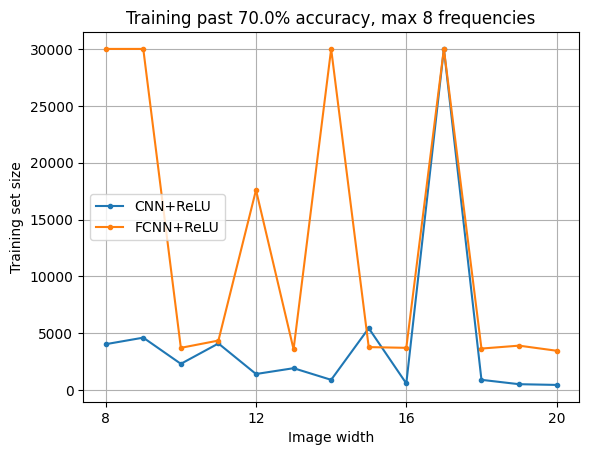

In [13]:
# Load data
with open(filepath, 'rb') as file:
    sample_complexity = pickle.load(file)
# Extract data to plot
names = set([name for name, _ in sample_complexity.keys()])

# For every model, make line plot
for i, name in enumerate(names):
    x, y = list(zip(*sorted([(int((dim)**0.5), tr_size) for (_name, dim), tr_size  in sample_complexity.items() if name == _name])))
    plt.plot(x, y, marker='.', linestyle='-', label=name)

# Plot graphics
plt.xlabel('Image width')
plt.ylabel('Training set size')
plt.xticks(ticks=[tick for tick in plt.xticks()[0]][1::2], labels=[tick for tick in plt.xticks()[1]][1::2])
plt.title(f'Training past {epsilon*100}% accuracy, max {freq} frequenc{"y" if freq==1 else "ies"}')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()